# 5. RNN
- 단순한 feed forward 신경망은 시계열 적인 데이터에 대해 취약한 특징을 보인다.
- 시계열 데이터의 패턴은 충분히 학습하기 위해 등장한 순환 신경망: RNN 에 대해 알아본다.

## Language Model
- 단어 나열에 확률을 부여하는 모델
- 특정한 단어 시퀀스에 대해, 그 시퀀스가 일어날 가능성이 어느 정도인지 확률로 평가하는 모델

$$P(w_1, ..., w_m) = P(w_m|w_1, ...,w_m)P(w_{m-1}|w_1, ..., w_{m-2})...P(w_2|w_1)P(w_1)$$
- 위 식을 해석하자면, 첫번째부터 m 번째의 단어까지 동시에 나타날 확률은 t번째보다 왼쪽에 (이전에) 나타난 단어의 확률을 조건부로 t번째 단어가 나탈 확률을 모두 곱한것과 같다.


#### Markov Model
- 미래의 상태가 현재 상태에만 의존되 결정되는 모델
- 어떤 Status 의 확률이 그 직전 N 개의 사건에만 의존할 때, N층 Markov Chain Model 이라 한다.

### RNN
- Recurrent : 순환
- 순환하기 위해서는 '닫힌 경로'가(=순환하는 경로) 필요
- 데이터가 이 경로를 통해 순환하면서 정보가 끊임없이 갱신

In [2]:
import sys
sys.path.append('./deep-learning-from-scratch-2/')

class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev


class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None

In [3]:
from common.layers import *


class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W
        
    def forward(self, xs):
        N, T = xs.shape
        V, D = self.W.shape
        
        out = np.empty((N, T, D), dtype='f')
        self.layers = []
        
        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)
        
        return out
    
    def backward(self, dout):
        N, T, D = dout.shape

        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None
    

class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None
        
    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params
        
        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)
    
    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params
        
        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)
        
        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*.shape)
        
        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx
        
        
    

In [4]:
class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 정답 레이블이 원핫 벡터인 경우
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)

        # 배치용과 시계열용을 정리(reshape)
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_label에 해당하는 데이터는 손실을 0으로 설정
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_label에 해당하는 데이터는 기울기를 0으로 설정

        dx = dx.reshape((N, T, V))

        return dx

In [16]:
import numpy as np
from common.time_layers import *

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # Initialize
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        
        rnn_b = np.zeros(H).astype('f')        
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # generate layers
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()
        x
        
        

말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼플렉서티 383.95
| 에폭 2 | 퍼플렉서티 258.72
| 에폭 3 | 퍼플렉서티 223.50
| 에폭 4 | 퍼플렉서티 215.01
| 에폭 5 | 퍼플렉서티 204.98
| 에폭 6 | 퍼플렉서티 201.68
| 에폭 7 | 퍼플렉서티 197.97
| 에폭 8 | 퍼플렉서티 194.95
| 에폭 9 | 퍼플렉서티 190.03
| 에폭 10 | 퍼플렉서티 191.51
| 에폭 11 | 퍼플렉서티 187.79
| 에폭 12 | 퍼플렉서티 191.39
| 에폭 13 | 퍼플렉서티 189.30
| 에폭 14 | 퍼플렉서티 190.20
| 에폭 15 | 퍼플렉서티 188.82
| 에폭 16 | 퍼플렉서티 185.39
| 에폭 17 | 퍼플렉서티 183.44
| 에폭 18 | 퍼플렉서티 179.92
| 에폭 19 | 퍼플렉서티 180.79
| 에폭 20 | 퍼플렉서티 182.04
| 에폭 21 | 퍼플렉서티 180.23
| 에폭 22 | 퍼플렉서티 176.68
| 에폭 23 | 퍼플렉서티 173.81
| 에폭 24 | 퍼플렉서티 174.62
| 에폭 25 | 퍼플렉서티 171.90
| 에폭 26 | 퍼플렉서티 172.20
| 에폭 27 | 퍼플렉서티 167.84
| 에폭 28 | 퍼플렉서티 165.77
| 에폭 29 | 퍼플렉서티 162.29
| 에폭 30 | 퍼플렉서티 157.80
| 에폭 31 | 퍼플렉서티 157.36
| 에폭 32 | 퍼플렉서티 152.76
| 에폭 33 | 퍼플렉서티 153.51
| 에폭 34 | 퍼플렉서티 147.82
| 에폭 35 | 퍼플렉서티 145.83
| 에폭 36 | 퍼플렉서티 138.89
| 에폭 37 | 퍼플렉서티 135.73
| 에폭 38 | 퍼플렉서티 131.71
| 에폭 39 | 퍼플렉서티 127.52
| 에폭 40 | 퍼플렉서티 122.64
| 에폭 41 | 퍼플렉서티 122.36
| 에폭 42 | 퍼플렉서티 117.04
| 에폭 43 | 퍼플렉서티 109

/Users/emjayahn/.pyenv/versions/3.6.0/envs/deeplearning/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['AppleMyungjo'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/emjayahn/.pyenv/versions/3.6.0/envs/deeplearning/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['AppleMyungjo'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


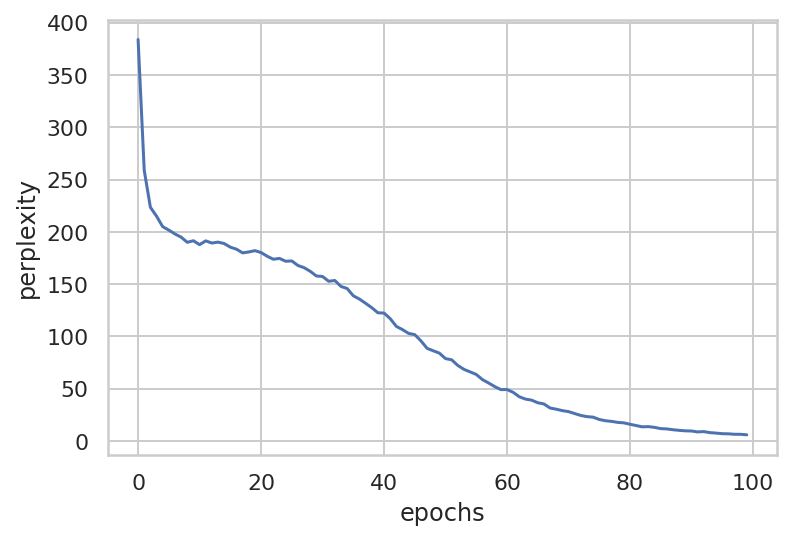

In [17]:
from common.optimizer import SGD
from dataset import ptb
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5
lr = 0.1
max_epoch = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]
ts = corpus[1:]

data_size = len(xs)
print("말뭉치 크기: {}, 어휘 수: {}".format(corpus_size, vocab_size))

max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1
            
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
    
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0
    
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()
